
# Mount the data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import os
import io
import cv2
import h5py
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from google.colab import output

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Build dataset and transform
## 1. Create custom dataset class
Reference: Implementing CNN in PyTorch with Custom Dataset and Transfer Learning </br>
https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc


In [ ]:
class dataset_h5(Dataset):
    def __init__(self, h5file_path, annotation_file, transform):
        self.h5file = h5py.File(h5file_path, 'r')        
        self.annotations = pd.read_csv(annotation_file, index_col='Frame')
        self.transform = transform
        self.key = list(self.h5file.keys())
        
    def __len__(self):
        return len(self.key)

    def __getitem__(self, index):
        img_id = self.key[index]
        img = Image.open(io.BytesIO(np.array(self.h5file[img_id]))) # read the image from h5 file data
        y_label = torch.tensor(self.annotations.loc[img_id][0])

        if self.transform is not None:
            img = self.transform(img)
        return (img, y_label)
          
          

## 2. Define transform and load the data

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
t = time.time()

trainingLoaderSet = []
testingLoaderSet = []

for eachDataset in range(8):

  print("Processing dataset %d... " %(eachDataset), end='')
  # Load training dataset
  datasetPath = "/content/drive/Shareddrives/Surgery Video Research Team/Frames/cholec80/TrainingDataset_sub/trainingData"+str(eachDataset)+'.hdf5'
  labelPath = "/content/drive/Shareddrives/Surgery Video Research Team/Frames/cholec80/TrainingDataset_sub/trainingData"+str(eachDataset)+"_lables.txt"

  train_data = dataset_h5(h5file_path=datasetPath, annotation_file=labelPath, transform=transform)
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True, num_workers=1)

  trainingLoaderSet.append(trainloader)

  # Load testing dataset
  datasetPath = "/content/drive/Shareddrives/Surgery Video Research Team/Frames/cholec80/TestingDataset_sub/testingData"+str(eachDataset)+'.hdf5'
  labelPath = "/content/drive/Shareddrives/Surgery Video Research Team/Frames/cholec80/TestingDataset_sub/testingData"+str(eachDataset)+"_lables.txt"

  test_data = dataset_h5(h5file_path=datasetPath, annotation_file=labelPath, transform=transform)
  testloader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True, num_workers=1)

  testingLoaderSet.append(testloader)

  print("Finish!")
print("Load all the dataset costs %d minutes %d seconds"%((time.time()-t)/60, (time.time()-t)%60))

Processing dataset 0... Finish!
Processing dataset 1... Finish!
Processing dataset 2... Finish!
Processing dataset 3... Finish!
Processing dataset 4... Finish!
Processing dataset 5... Finish!
Processing dataset 6... Finish!
Processing dataset 7... Finish!
Load all the dataset costs 10 minutes 46 seconds


In [ ]:
valLoaderSet = testingLoaderSet[0:2]

# Construct  AlexNet
Reference: Implementing AlexNet Using PyTorch As A Transfer Learning Model In Multi-Class Classification </br> https://analyticsindiamag.com/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/
## 1. Load the pre-trained model from Pytorch

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Model description
AlexNet_model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 2. Modify the output layer from 1000 to 7

 

In [ ]:
#Updating the second classifier
#AlexNet_model.classifier[4] = nn.Linear(4096,4096)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
AlexNet_model.classifier[6] = nn.Linear(4096,7)
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 3. Setup CUDA to speed up 

In [ ]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
param_classifier1 = []
param_classifier2 = []
for idx, m in enumerate(AlexNet_model.modules()):
  if idx == 18 or idx == 21:
    print(idx, '->', m)
    param_classifier1.append(m.weight)
  if idx == 23:
    print(idx, '->', m)
    param_classifier2.append(m.weight)

18 -> Linear(in_features=9216, out_features=4096, bias=True)
21 -> Linear(in_features=4096, out_features=4096, bias=True)
23 -> Linear(in_features=4096, out_features=7, bias=True)


## 4. Define the optimizer, loss functions and turn the model into training state

`model.eval()` will affect the dropout layer and batch normalization. **You need to turn model into** `model.train()` **during model training process**.</br>
Reference: [What does model.eval() do in pytorch? | Stackoverflow](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch)



In [ ]:
#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD([
      {'params': AlexNet_model.features.parameters()},
      {'params': param_classifier1},
      {'params': param_classifier2, 'lr': 0.01}], 
      lr=0.001, momentum=0.9)

optimizer_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)

# Turn the model into training mode
AlexNet_model.train()
print("Is the model in training mode?",AlexNet_model.training)

Is the model in training mode? True


## 5. Train the model 

In [ ]:
def train_model(model, trainingLoaderSet, testingLoaderSet, criterion, optimizer, lr_scheduler, num_epochs = 30):
  '''
  It will return:
    1. Training and Testing loss record: running_Loss, val_Loss
    2. Training and Testing accuracy record: running_Acc, val_Acc
  '''
  running_Loss = []
  val_Loss = []
  running_Acc = []
  val_Acc = []

  startTime = time.time()

  startTime = time.time() # record the start time of training process
  pbar_all = tqdm(total=num_epochs, desc="Total training progress", ncols=700) # display the progress of training process

  for epoch in range(num_epochs):  # loop over the dataset multiple times

    loss_train = 0
    correct_train = 0
    total_train = 0
    loss_test = 0
    correct_test = 0
    total_test = 0

    model.train() # Trun the mode into training state

    # Training process
    pbar = tqdm(total=sum([len(item) for item in trainingLoaderSet]), desc="Epoch %d training progress"%(epoch), ncols=700) 
    for DatasetIndex, eachDataset in enumerate(trainingLoaderSet): # loop over the 8 sub-dataset
      for i, data in enumerate(eachDataset, 0):
        # send the input to GPU memory; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        
        optimizer.zero_grad()  # zero the parameter gradients  
        output = model(inputs) # forward propagation
        loss = criterion(output, labels) # caculate the loss between output and ground truth 
        loss.backward() # backward propagation        
        optimizer.step() # update the gradient to new gradients        
        loss_train += loss.item() # Caculate the loss and the number of correct predicted results 

        # caculate the running loss and accuracy
        model.eval() # turn the model into evaluation mode
        with torch.no_grad(): # turn off the gradient descent process
          output = model(inputs)
          _, predicted = torch.max(output.data, 1)
          correct_train += (predicted == labels).sum().item()
          total_train += labels.size(0)

        model.train()
        pbar.update(1)
    
    lr_scheduler.step()
    
    running_Loss.append([epoch, (loss_train / total_train)])
    running_Acc.append([epoch, (correct_train / total_train)])
    #pbar.close()


    

    # Testing process, evaluate the model through the testing dataset
    model.eval()
    with torch.no_grad():
      pbar = tqdm(total=sum([len(item) for item in testingLoaderSet]), desc="Epoch %d testing progress"%(epoch), ncols=700) 
      for DatasetIndex, eachDataset_test in enumerate(testingLoaderSet):
        for i, data in enumerate(eachDataset_test):
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          loss = criterion(outputs, labels) 
          _, predicted = torch.max(outputs.data, 1)       
          correct_test += (predicted == labels).sum().item()
          total_test += labels.size(0)
          loss_test += loss.item()

          pbar.update(1)

    val_Loss.append([epoch, (loss_test / total_test)])
    val_Acc.append([epoch, (correct_test / total_test)])
    #pbar.close()

    print('Epoch %d  |  Running Loss: %.6f  |  Validation Loss: %.6f  |  Running Accuracy: %.3f%%  |  Validataion Accuracy: %.3f%%  |  ' 
       %(epoch, (loss_train / total_train), (loss_test / total_test), (100 * correct_train / total_train), (100 * correct_test / total_test)))    
    print('Learning Rate:',end='')
    for item in optimizer.param_groups:
      print(' '+ str(item['lr']) + ',',end='')

    pbar_all.update(1)
  pbar_all.close()
  
  torch.save(model, '/content/drive/Shareddrives/Surgery Video Research Team/Code/EndoNetModel.pkl')
  print("Train the model cost total %d hours %d minutes"%((time.time() - startTime)/3600,(time.time() - startTime)%60))

  return running_Loss, val_Loss, running_Acc, val_Acc

  


In [ ]:
running_Loss, val_Loss, running_Acc, val_Acc = train_model(AlexNet_model,
                                trainingLoaderSet, valLoaderSet, 
                                criterion, optimizer, lr_scheduler = optimizer_scheduler, 
                                num_epochs = 30)

Epoch 0  |  Running Loss: 0.010585  |  Validation Loss: 0.020669  |  Running Accuracy: 85.015%  |  Validataion Accuracy: 64.532%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 1  |  Running Loss: 0.006636  |  Validation Loss: 0.019072  |  Running Accuracy: 91.026%  |  Validataion Accuracy: 68.746%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 2  |  Running Loss: 0.005100  |  Validation Loss: 0.019296  |  Running Accuracy: 93.626%  |  Validataion Accuracy: 70.011%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 3  |  Running Loss: 0.004072  |  Validation Loss: 0.020328  |  Running Accuracy: 95.120%  |  Validataion Accuracy: 70.457%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 4  |  Running Loss: 0.003432  |  Validation Loss: 0.020794  |  Running Accuracy: 96.233%  |  Validataion Accuracy: 73.308%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 5  |  Running Loss: 0.002938  |  Validation Loss: 0.020973  |  Running Accuracy: 96.892%  |  Validataion Accuracy: 73.283%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 6  |  Running Loss: 0.002509  |  Validation Loss: 0.022168  |  Running Accuracy: 97.465%  |  Validataion Accuracy: 72.506%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 7  |  Running Loss: 0.002226  |  Validation Loss: 0.023823  |  Running Accuracy: 98.004%  |  Validataion Accuracy: 73.209%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 8  |  Running Loss: 0.001979  |  Validation Loss: 0.024069  |  Running Accuracy: 98.291%  |  Validataion Accuracy: 72.837%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 9  |  Running Loss: 0.001820  |  Validation Loss: 0.023526  |  Running Accuracy: 98.495%  |  Validataion Accuracy: 74.453%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 10  |  Running Loss: 0.001602  |  Validation Loss: 0.022777  |  Running Accuracy: 98.715%  |  Validataion Accuracy: 74.700%  |  
Learning Rate: 0.001, 0.001, 0.01,

Epoch 11  |  Running Loss: 0.001459  |  Validation Loss: 0.023990  |  Running Accuracy: 98.946%  |  Validataion Accuracy: 74.391%  |  
Learning Rate: 0.0001, 0.0001, 0.001,

Epoch 12  |  Running Loss: 0.001630  |  Validation Loss: 0.021209  |  Running Accuracy: 98.542%  |  Validataion Accuracy: 76.209%  |  
Learning Rate: 0.0001, 0.0001, 0.001,

Epoch 13  |  Running Loss: 0.001371  |  Validation Loss: 0.021255  |  Running Accuracy: 98.876%  |  Validataion Accuracy: 76.638%  |  
Learning Rate: 0.0001, 0.0001, 0.001,

Buffered data was truncated after reaching the output size limit.

In [ ]:
print(running_Loss)

[[0, 0.01058544699870282], [1, 0.006635504169385289], [2, 0.005100301488928623], [3, 0.004071690353025272], [4, 0.0034317018374403394], [5, 0.002938401746496665], [6, 0.0025092405607171028], [7, 0.002225729002336988], [8, 0.0019787180651818555], [9, 0.0018195383838363606], [10, 0.0016019444936185363], [11, 0.001459271834730895], [12, 0.0016296818340231737], [13, 0.0013706936457954229], [14, 0.0012765401907051527], [15, 0.001213541973512735], [16, 0.0011364922226477219], [17, 0.0011176880574581057], [18, 0.0010703411170375008], [19, 0.0010383717466810796], [20, 0.0009916887612933926], [21, 0.0009811993524702428], [22, 0.0009528852621785569], [23, 0.000940911806252815], [24, 0.0012814510928806817], [25, 0.0011286846759290745], [26, 0.0011179516541448993], [27, 0.001101120247123778], [28, 0.001110812047400089], [29, 0.0010785768991597724]]


In [ ]:
running_Loss = [[0, 0.01058544699870282], [1, 0.006635504169385289], [2, 0.005100301488928623], [3, 0.004071690353025272], [4, 0.0034317018374403394], [5, 0.002938401746496665], [6, 0.0025092405607171028], [7, 0.002225729002336988], [8, 0.0019787180651818555], [9, 0.0018195383838363606], [10, 0.0016019444936185363], [11, 0.001459271834730895], [12, 0.0016296818340231737], [13, 0.0013706936457954229], [14, 0.0012765401907051527], [15, 0.001213541973512735], [16, 0.0011364922226477219], [17, 0.0011176880574581057], [18, 0.0010703411170375008], [19, 0.0010383717466810796], [20, 0.0009916887612933926], [21, 0.0009811993524702428], [22, 0.0009528852621785569], [23, 0.000940911806252815], [24, 0.0012814510928806817], [25, 0.0011286846759290745], [26, 0.0011179516541448993], [27, 0.001101120247123778], [28, 0.001110812047400089], [29, 0.0010785768991597724]]
val_Loss = [[0, 0.020669288777505138], [1, 0.019071842926207203], [2, 0.01929577242014438], [3, 0.020327939738489245], [4, 0.020794226273644335], [5, 0.020973056379935632], [6, 0.022168395126637284], [7, 0.023823107132756968], [8, 0.024068861236829185], [9, 0.0235262537363856], [10, 0.022777156443950432], [11, 0.023989569202758746], [12, 0.02120895478860592], [13, 0.021254667171061843], [14, 0.021727258401402078], [15, 0.021759098478362892], [16, 0.022229079010885378], [17, 0.021998331584907566], [18, 0.02287866046678211], [19, 0.022586760659664487], [20, 0.022611384208835697], [21, 0.022675112599125087], [22, 0.023596381819533392], [23, 0.023051728836101654], [24, 0.022639006222341586], [25, 0.022849085253803664], [26, 0.02288416974414588], [27, 0.022804562731100875], [28, 0.02272077429103473], [29, 0.02288197459105509]]
running_Acc = [[0, 0.8501459955506118], [1, 0.9102590841675936], [2, 0.9362601965146459], [3, 0.9511957730812013], [4, 0.9623308305524657], [5, 0.9689238042269188], [6, 0.974647756766778], [7, 0.9800356878012607], [8, 0.9829092510196514], [9, 0.9849485539488321], [10, 0.9871500741564702], [11, 0.9894558769002596], [12, 0.9854236188357434], [13, 0.9887606599925843], [14, 0.9899309417871709], [15, 0.9901974416017798], [16, 0.9909969410456062], [17, 0.9916342232109752], [18, 0.9918427882832778], [19, 0.9923526140155728], [20, 0.9926422877271042], [21, 0.992908787541713], [22, 0.9933490915832406], [23, 0.9934533741193919], [24, 0.9903596588802372], [25, 0.991947070819429], [26, 0.9923178531701891], [27, 0.9921208750463478], [28, 0.9923294401186503], [29, 0.9923989618094179]]
val_Acc = [[0, 0.6453185687133295], [1, 0.6874638459631436], [2, 0.7001074291380878], [3, 0.7045698702586564], [4, 0.7330799107511776], [5, 0.7328319973555905], [6, 0.7250640442938601], [7, 0.732088257168829], [8, 0.7283695562350219], [9, 0.7445252458474506], [10, 0.747004379803322], [11, 0.7439054623584828], [12, 0.7620857780348731], [13, 0.7663829435583837], [14, 0.7679943806297], [15, 0.7672506404429386], [16, 0.7689860342120486], [17, 0.7684488885216098], [18, 0.7675811916370547], [19, 0.7710519791752748], [20, 0.7709280224774812], [21, 0.7719609949590943], [22, 0.7686141641186679], [23, 0.7691099909098421], [24, 0.7758862903892241], [25, 0.7762994793818693], [26, 0.7750599124039336], [27, 0.77667134947525], [28, 0.7765060738781919], [29, 0.7768366250723081]]


In [ ]:
print(val_Loss) 

[[0, 0.020669288777505138], [1, 0.019071842926207203], [2, 0.01929577242014438], [3, 0.020327939738489245], [4, 0.020794226273644335], [5, 0.020973056379935632], [6, 0.022168395126637284], [7, 0.023823107132756968], [8, 0.024068861236829185], [9, 0.0235262537363856], [10, 0.022777156443950432], [11, 0.023989569202758746], [12, 0.02120895478860592], [13, 0.021254667171061843], [14, 0.021727258401402078], [15, 0.021759098478362892], [16, 0.022229079010885378], [17, 0.021998331584907566], [18, 0.02287866046678211], [19, 0.022586760659664487], [20, 0.022611384208835697], [21, 0.022675112599125087], [22, 0.023596381819533392], [23, 0.023051728836101654], [24, 0.022639006222341586], [25, 0.022849085253803664], [26, 0.02288416974414588], [27, 0.022804562731100875], [28, 0.02272077429103473], [29, 0.02288197459105509]]


In [ ]:
print(running_Acc) 

[[0, 0.8501459955506118], [1, 0.9102590841675936], [2, 0.9362601965146459], [3, 0.9511957730812013], [4, 0.9623308305524657], [5, 0.9689238042269188], [6, 0.974647756766778], [7, 0.9800356878012607], [8, 0.9829092510196514], [9, 0.9849485539488321], [10, 0.9871500741564702], [11, 0.9894558769002596], [12, 0.9854236188357434], [13, 0.9887606599925843], [14, 0.9899309417871709], [15, 0.9901974416017798], [16, 0.9909969410456062], [17, 0.9916342232109752], [18, 0.9918427882832778], [19, 0.9923526140155728], [20, 0.9926422877271042], [21, 0.992908787541713], [22, 0.9933490915832406], [23, 0.9934533741193919], [24, 0.9903596588802372], [25, 0.991947070819429], [26, 0.9923178531701891], [27, 0.9921208750463478], [28, 0.9923294401186503], [29, 0.9923989618094179]]


In [ ]:
print(val_Acc)

[[0, 0.6453185687133295], [1, 0.6874638459631436], [2, 0.7001074291380878], [3, 0.7045698702586564], [4, 0.7330799107511776], [5, 0.7328319973555905], [6, 0.7250640442938601], [7, 0.732088257168829], [8, 0.7283695562350219], [9, 0.7445252458474506], [10, 0.747004379803322], [11, 0.7439054623584828], [12, 0.7620857780348731], [13, 0.7663829435583837], [14, 0.7679943806297], [15, 0.7672506404429386], [16, 0.7689860342120486], [17, 0.7684488885216098], [18, 0.7675811916370547], [19, 0.7710519791752748], [20, 0.7709280224774812], [21, 0.7719609949590943], [22, 0.7686141641186679], [23, 0.7691099909098421], [24, 0.7758862903892241], [25, 0.7762994793818693], [26, 0.7750599124039336], [27, 0.77667134947525], [28, 0.7765060738781919], [29, 0.7768366250723081]]


## Plot the epoch, accuracy and loss graphs

Accuracy

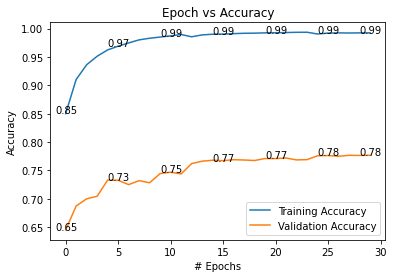

In [ ]:
plt.figure()
plt.plot([item[0] for item in running_Acc], [item[1] for item in running_Acc], label='Training Accuracy')
plt.plot([item[0] for item in val_Acc], [item[1] for item in val_Acc], label='Validation Accuracy')
for x in range(0,30,5):  
  y = running_Acc[x][1]
  s = str(round(running_Acc[x][1],2))
  plt.text(x-1, y, s, fontsize=10)
plt.text(29-1, running_Acc[29][1], round(running_Acc[29][1],2), fontsize=10)
for x in range(0,30,5):  
  y = val_Acc[x][1]
  s = str(round(val_Acc[x][1],2))
  plt.text(x-1, y, s, fontsize=10)
plt.text(29-1, val_Acc[29][1], round(val_Acc[29][1],2), fontsize=10)
plt.xlabel("# Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Epoch vs Accuracy")
plt.savefig('EpochvsAcc.jpg')
plt.show()



Loss

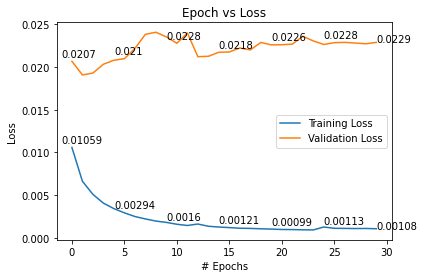

In [ ]:
plt.figure()
plt.plot([item[0] for item in running_Loss], [item[1] for item in running_Loss], label = "Training Loss")
plt.plot([item[0] for item in val_Loss], [item[1] for item in val_Loss], label = "Validation Loss")
for x in range(0,30,5):  
  y = running_Loss[x][1]
  s = str(round(running_Loss[x][1],5))
  plt.text(x-1, y+0.0005, s, fontsize=10)
plt.text(29, running_Loss[29][1], round(running_Loss[29][1],5), fontsize=10)
for x in range(0,30,5):  
  y = val_Loss[x][1]
  s = str(round(val_Loss[x][1],4))
  plt.text(x-1, y+0.0005, s, fontsize=10)
plt.text(29, val_Loss[29][1], round(val_Loss[29][1],4), fontsize=10)

plt.xlabel("# Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Epoch vs Loss")
plt.savefig('EpochvsLoss.jpg')
plt.show()

## Load the model and using CUDA to speed up 

In [ ]:
AlexNet_model = torch.load("/content/drive/Shareddrives/Surgery Video Research Team/Code/EndoNetModel.pkl")

#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)


cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 6. Testing the model 

In [ ]:
correct = 0
total = 0
predictedList = []
startTime = time.time()

AlexNet_model.eval()
pbar = tqdm(total=sum([len(item) for item in testingLoaderSet]), desc="Testing progress", ncols=700) 
with torch.no_grad():
  for DatasetIndex, eachDataset in enumerate(testingLoaderSet): 
    for i, data in enumerate(eachDataset):
      images, labels = data[0].to(device), data[1].to(device)
      outputs = AlexNet_model(images)
      _, predicted = torch.max(outputs.data, 1)
      predictedList.append([predicted.tolist(), labels.tolist(), DatasetIndex])

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      pbar.update(1)
pbar.close()

print('Accuracy of the network on the testing dataset: %.2f %%' %(100 * correct / total))
print("Test the model cost total %d minutes"%((time.time() - startTime)/60))



Accuracy of the network on the testing dataset: 72.46 %
Test the model cost total 28 minutes


## Metrics
Plot the confusion matrix

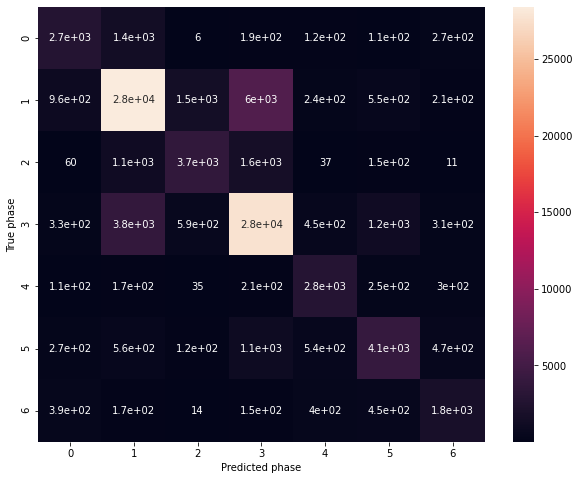

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plotConfusionMatrix(y_true, y_predicted):
  confmat = confusion_matrix(y_true, y_predicted)
  plt.figure(figsize=(10,8))
  sn.heatmap(confmat, annot=True)
  plt.xlabel("Predicted phase")
  plt.ylabel("True phase")
  plt.show()

phaseTrue = []
phasePredicted = []

for index, item in enumerate(predictedList):
  phaseTrue += item[1]
  phasePredicted += item[0]

plotConfusionMatrix(phaseTrue, phasePredicted)

Accuracy, Recall, F1 score and Precision

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score


print("Accuracy: %.2f%%"%(accuracy_score(phaseTrue, phasePredicted)*100))
print("Recll: %.2f%%"%(recall_score(phaseTrue, phasePredicted, average='weighted')*100))
print("F1 score: %.2f%%"%(f1_score(phaseTrue, phasePredicted, average='weighted')*100))
print("Precision score: %.2f%%"%(precision_score(phaseTrue, phasePredicted, average='weighted')*100))

Accuracy: 72.46%
Recll: 72.46%
F1 score: 72.39%
Precision score: 72.52%
